## Georeferencing Land Cover

In [2]:
import rasterio
from rasterio.transform import from_bounds
import numpy as np

# Path to your input TIFF (your solar map)
input_tiff = 'land_cover.tif'

# Path to save the georeferenced TIFF
output_tiff = 'land_cover_georef_utm.tif'

# Your bounding box coordinates in EPSG:32736 (UTM meters)
# Replace these with your exact UTM bounds (xmin, ymin, xmax, ymax)
xmin, ymin =96522.29161251272, 8703974.844513323, 
xmax,  ymax=1336843.9731235446, 9888509.76626699,

with rasterio.open(input_tiff) as src:
    img = src.read()
    height, width = img.shape[1], img.shape[2]

# Create transform using your UTM bounding box and image dimensions
transform = from_bounds(xmin, ymin, xmax, ymax, width, height)

# Write georeferenced image with correct CRS and transform
with rasterio.open(
    output_tiff,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=img.shape[0],
    dtype=img.dtype,
    crs='EPSG:32736',
    transform=transform
) as dst:
    dst.write(img)

print(f"Georeferenced image saved as {output_tiff}")


Georeferenced image saved as land_cover_georef_utm.tif


## Clipping Land Cover to Tanzania Boundary 

In [11]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd

# --- Step 1: Load Tanzania boundary shapefile ---
gdf = gpd.read_file("Tanzania_Boundary_UTM.shp")
gdf = gdf.to_crs("EPSG:32736")  # Your raster is in UTM Zone 36S

# --- Step 2: Open the already georeferenced solar GHI raster ---
with rasterio.open("land_cover_georef_utm.tif") as src:
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()

# --- Step 3: Update metadata and save clipped raster ---
out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

with rasterio.open("landcover_clipped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

print("✅ Done: The raster is now clipped and aligned to Tanzania's boundary.")

✅ Done: The raster is now clipped and aligned to Tanzania's boundary.


## Solar Suitability Map

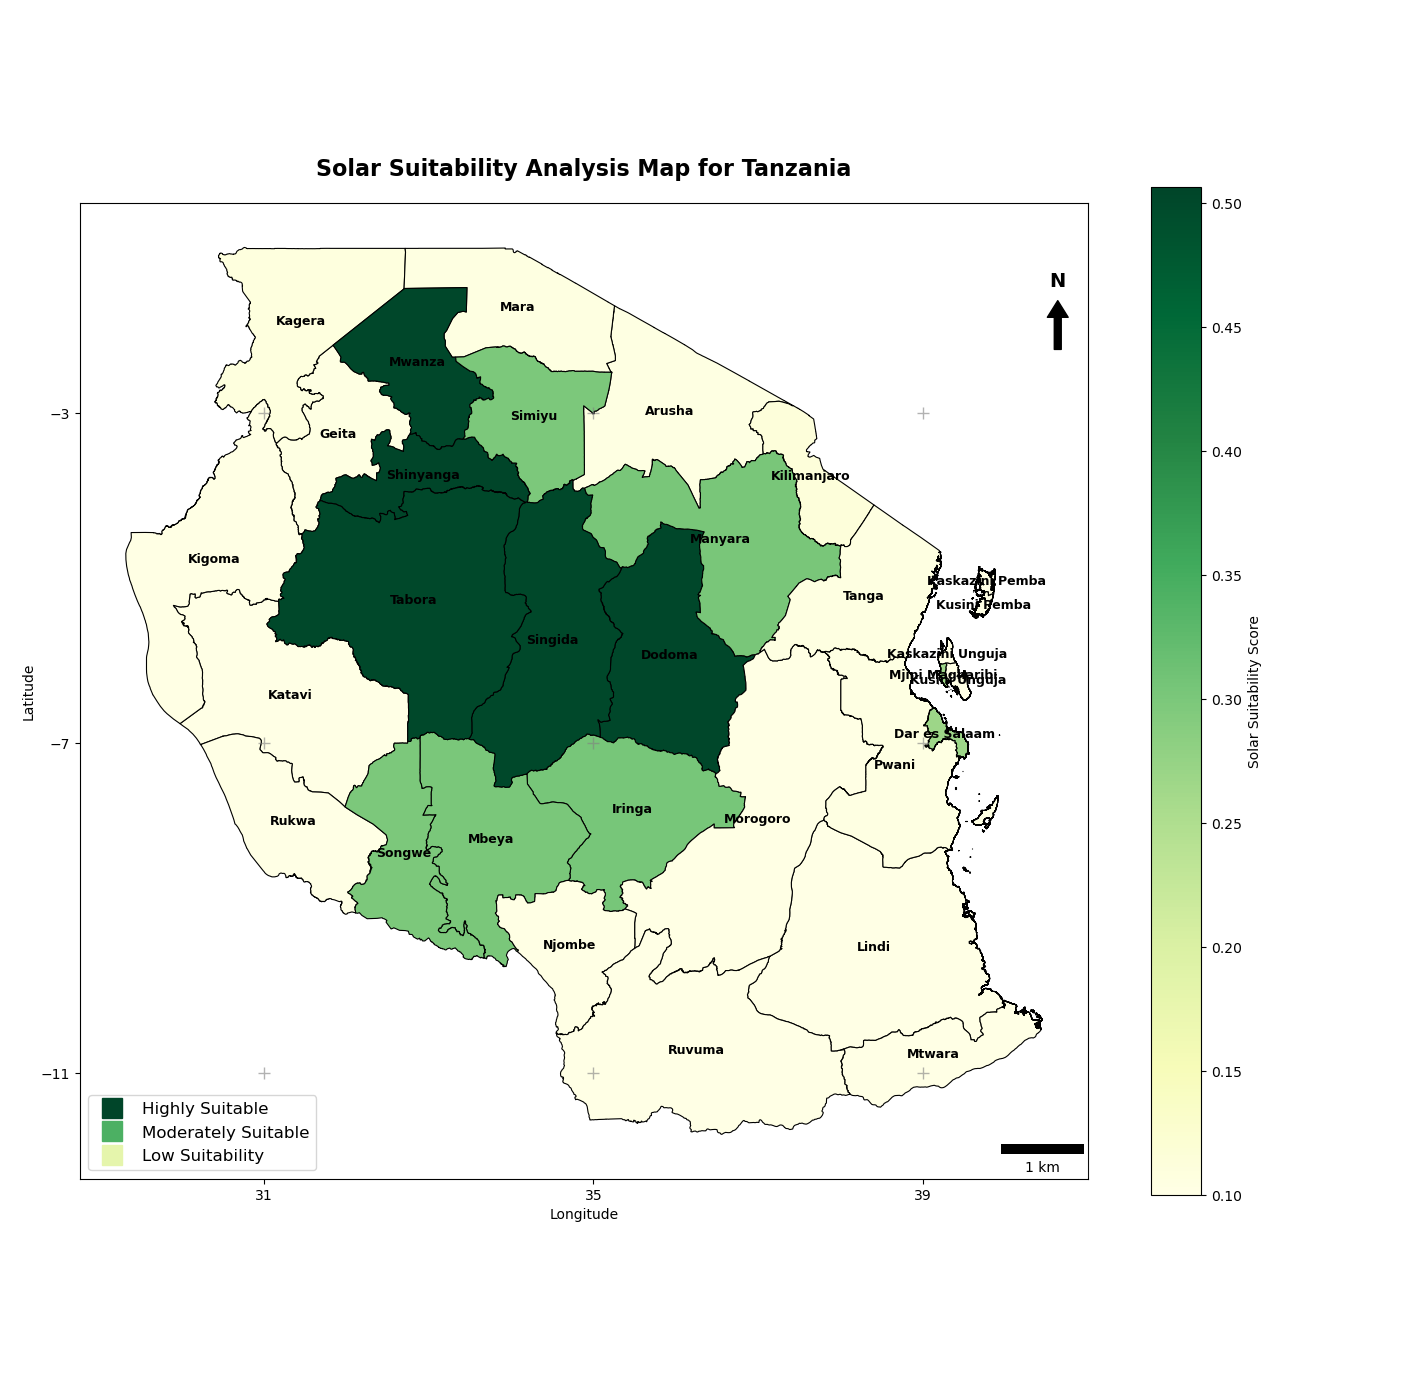

In [9]:
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import geometry_mask
from shapely.ops import unary_union
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar

# --- 1. Load Tanzania boundary (regions shapefile) ---
tz_boundary = gpd.read_file("Tanzania_Boundary_UTM.shp")
if tz_boundary.crs.to_string() != "EPSG:32736":
    tz_boundary = tz_boundary.to_crs("EPSG:32736")
tz_boundary_4326 = tz_boundary.to_crs("EPSG:4326")

# --- 2. Load Solar GHI raster, reproject to EPSG:4326 ---
with rasterio.open("Tanzania_Solar_GHI.tif") as src:
    dst_crs = "EPSG:4326"
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    ghi_meta = src.meta.copy()
    ghi_meta.update({"crs": dst_crs, "transform": transform, "width": width, "height": height})

    ghi_data_reproj = np.empty((src.count, height, width), dtype=src.meta['dtype'])
    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=ghi_data_reproj[i - 1],
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest,
        )
    ghi_data = ghi_data_reproj[0]
    ghi_transform = transform

# --- 3. Threshold GHI for suitability ---
solar_mask = ghi_data > 5.0  # boolean mask for good solar

# --- 4. Load substation buffer shapefile, reproject ---
substations_buf = gpd.read_file("combined_substation_buffer.shp")
if substations_buf.crs.to_string() != "EPSG:4326":
    substations_buf = substations_buf.to_crs("EPSG:4326")

substations_union = unary_union(substations_buf.geometry)

# Create mask: True inside substation buffer polygons (suitable)
grid_mask = geometry_mask(
    [substations_union],
    invert=True,
    transform=ghi_transform,
    out_shape=solar_mask.shape,
)

# --- 5. Combine masks (GHI and Substation proximity) ---
final_mask = solar_mask & grid_mask

# --- 6. Aggregate raster mask by region polygon ---
def raster_mean_in_region(raster, raster_transform, polygons):
    """Calculate mean raster value inside each polygon."""
    means = []
    for poly in polygons:
        mask = geometry_mask([poly], transform=raster_transform, invert=True, out_shape=raster.shape)
        if np.any(mask):
            means.append(raster[mask].mean())
        else:
            means.append(np.nan)
    return means

tz_boundary_4326['solar_ghi_suitability'] = raster_mean_in_region(final_mask, ghi_transform, tz_boundary_4326.geometry)

# --- 7. Add regional suitability from external source (example scores) ---
region_scores = {
    **{r: 1.0 for r in ["Dodoma", "Tabora", "Singida", "Shinyanga", "Mwanza" ]},
    **{r: 0.6 for r in ["Iringa", "Songwe", "Mbeya", "Manyara", "Simiyu"]},
    **{r: 0.2 for r in ["Ruvuma", "Mtwara", "Kigoma", "Kilimanjaro"]}
}
tz_boundary_4326["region_score"] = tz_boundary_4326["NAME_1"].map(region_scores).fillna(0.2)

# --- 8. Combine criteria into final suitability score (weights adjustable) ---
tz_boundary_4326['final_score'] = (
    0.5 * tz_boundary_4326['solar_ghi_suitability'].fillna(0) +
    0.5 * tz_boundary_4326['region_score']
)

# --- 9. Plotting ---
fig, ax = plt.subplots(figsize=(14, 16))

cmap = plt.colormaps["YlGn"]

# Plot suitability by region
tz_boundary_4326.plot(
    column='final_score',
    cmap=cmap,
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Solar Suitability Score", 'shrink': 0.7},
    ax=ax
)

# Add region labels at region centroids
for idx, row in tz_boundary_4326.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['NAME_1'], fontsize=9, ha='center', va='center', color='black', weight='bold')

# Grid marks (optional)
x_ticks = np.linspace(31, 39, 3)
y_ticks = np.linspace(-3, -11, 3)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
for x in x_ticks:
    for y in y_ticks:
        ax.plot(x, y, marker='+', color='grey', markersize=8, alpha=0.6)

# North arrow
arrow_x, arrow_y = 0.97, 0.90
ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y - 0.05),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center')
ax.text(arrow_x, arrow_y + 0.02, 'N', transform=ax.transAxes,
        ha='center', va='center', fontsize=14, fontweight='bold')

# Scale bar setup: create new axes for scalebar with aspect=1, position inside plot lower right
tz_boundary_utm = tz_boundary.to_crs("EPSG:32736")  # back to UTM for scalebar
ax_utm = fig.add_axes([0, 0, 1, 1], frameon=False)
ax_utm.set_xlim(tz_boundary_utm.total_bounds[[0, 2]])
ax_utm.set_ylim(tz_boundary_utm.total_bounds[[1, 3]])
ax_utm.axis('off')
ax_utm.set_aspect(1)

# Add scalebar on ax_utm with length_fraction to position near lower right inside
ax.set_aspect(1)

# Add scalebar inside the main axes near lower right, with units in km
scalebar = ScaleBar(dx=1, units='km', dimension='si-length', location='lower right', box_alpha=0.3, length_fraction=0.15)

ax.add_artist(scalebar)


# Legend for suitability categories (custom)
legend_lines = [
    mlines.Line2D([], [], color=cmap(1.0), marker='s', linestyle='', markersize=15, label='Highly Suitable'),
    mlines.Line2D([], [], color=cmap(0.6), marker='s', linestyle='', markersize=15, label='Moderately Suitable'),
    mlines.Line2D([], [], color=cmap(0.2), marker='s', linestyle='', markersize=15, label='Low Suitability'),
]
ax.legend(handles=legend_lines, loc='lower left', fontsize=12, frameon=True)

# Titles and labels
ax.set_title("Solar Suitability Analysis Map for Tanzania", fontsize=16, weight='bold', pad=20)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal', adjustable='box')

# Disable tight_layout to avoid warning; use manual adjust instead
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

plt.show()


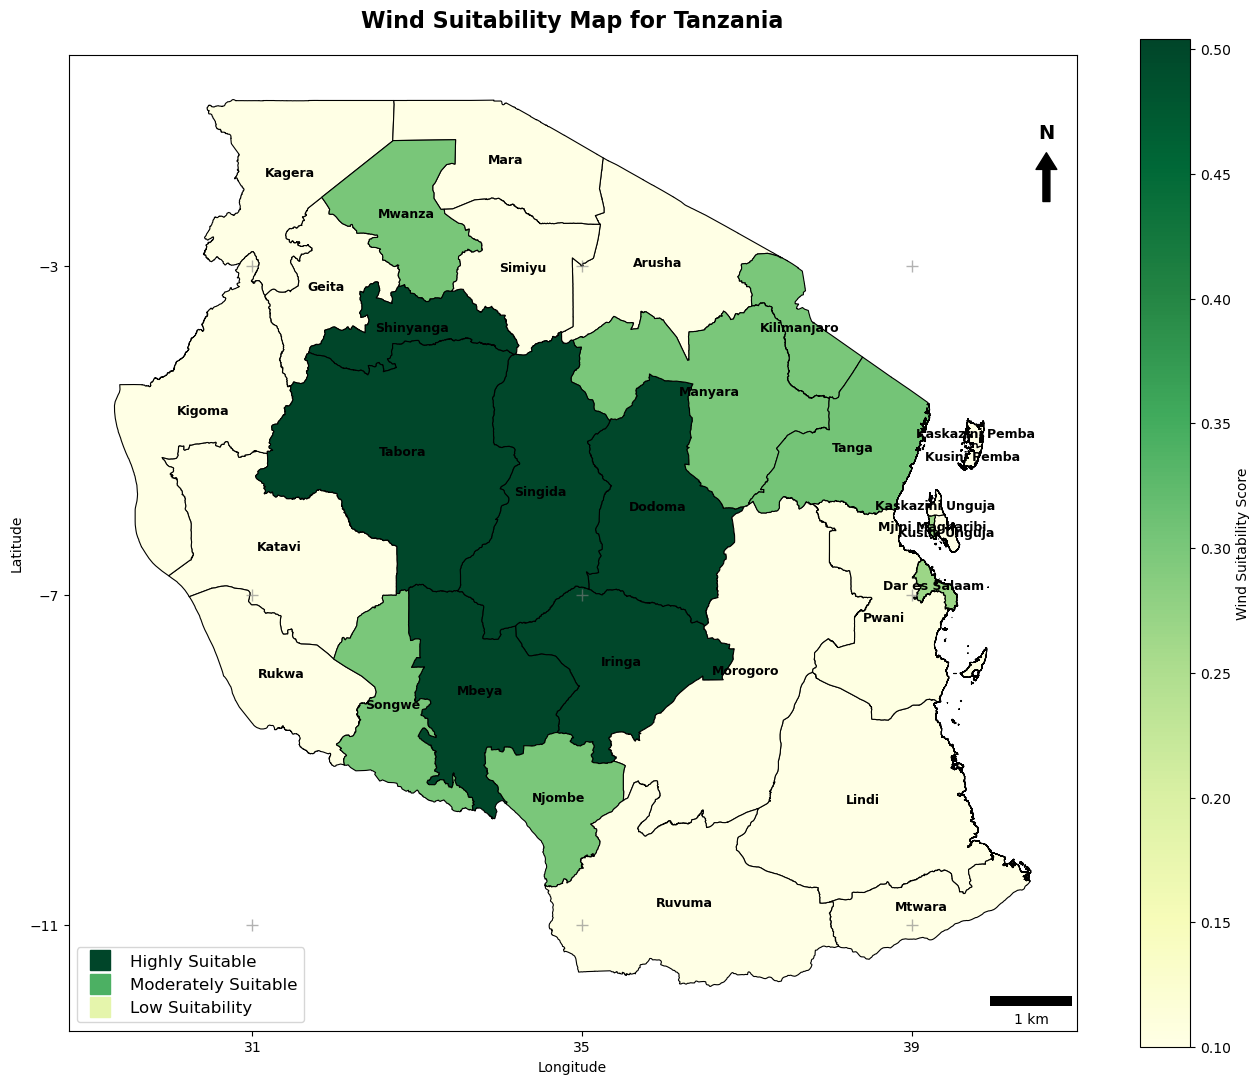

In [13]:
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import geometry_mask
from shapely.ops import unary_union
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar

# --- 1. Load Tanzania boundary (regions shapefile) ---
tz_boundary = gpd.read_file("Tanzania_Boundary_UTM.shp")
if tz_boundary.crs.to_string() != "EPSG:32736":
    tz_boundary = tz_boundary.to_crs("EPSG:32736")
tz_boundary_4326 = tz_boundary.to_crs("EPSG:4326")

# --- 2. Load Wind Speed raster, reproject to EPSG:4326 ---
# Replace "Tanzania_Wind_Speed.tif" with your actual wind speed raster file
with rasterio.open("Tanzania_Wind_Speed.tif") as src:
    dst_crs = "EPSG:4326"
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    wind_meta = src.meta.copy()
    wind_meta.update({"crs": dst_crs, "transform": transform, "width": width, "height": height})

    wind_data_reproj = np.empty((src.count, height, width), dtype=src.meta['dtype'])
    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=wind_data_reproj[i - 1],
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest,
        )
    wind_data = wind_data_reproj[0]
    wind_transform = transform

# --- 3. Threshold Wind Speed for suitability ---
# Example threshold: wind speed > 5 m/s (adjust based on your criteria)
wind_mask = wind_data > 5.0  # boolean mask for good wind suitability

# --- 4. Load substation buffer shapefile, reproject ---
substations_buf = gpd.read_file("combined_substation_buffer.shp")
if substations_buf.crs.to_string() != "EPSG:4326":
    substations_buf = substations_buf.to_crs("EPSG:4326")

substations_union = unary_union(substations_buf.geometry)

# Create mask: True inside substation buffer polygons (suitable proximity)
grid_mask = geometry_mask(
    [substations_union],
    invert=True,
    transform=wind_transform,
    out_shape=wind_mask.shape,
)

# --- 5. Combine masks (Wind speed and Substation proximity) ---
final_mask = wind_mask & grid_mask

# --- 6. Aggregate raster suitability mask by region polygon ---
def raster_mean_in_region(raster, raster_transform, polygons):
    """Calculate mean raster value inside each polygon."""
    means = []
    for poly in polygons:
        mask = geometry_mask([poly], transform=raster_transform, invert=True, out_shape=raster.shape)
        if np.any(mask):
            means.append(raster[mask].mean())
        else:
            means.append(np.nan)
    return means

tz_boundary_4326['wind_suitability'] = raster_mean_in_region(final_mask, wind_transform, tz_boundary_4326.geometry)

# --- 7. Add regional suitability from external source (example scores) ---
region_scores = {
    **{r: 1.0 for r in ["Dodoma", "Tabora", "Singida", "Iringa", "Mbeya", "Shinyanga"]},
    **{r: 0.6 for r in ["Mwanza", "Songwe", "Kilimanjaro", "Tanga", "Manyara", "Njombe"]},
    **{r: 0.2 for r in ["Dar es Salaam", "Mtwara", "Kigoma","Rukwa", "Ruvuma" ]}
}
tz_boundary_4326["region_score"] = tz_boundary_4326["NAME_1"].map(region_scores).fillna(0.2)

# --- 8. Combine criteria into final suitability score (weights adjustable) ---
tz_boundary_4326['final_score'] = (
    0.5 * tz_boundary_4326['wind_suitability'].fillna(0) +
    0.5 * tz_boundary_4326['region_score']
)

# --- 9. Plotting ---
fig, ax = plt.subplots(figsize=(14, 16))
cmap = plt.colormaps["YlGn"]

# Plot suitability by region
tz_boundary_4326.plot(
    column='final_score',
    cmap=cmap,
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Wind Suitability Score", 'shrink': 0.7},
    ax=ax
)

# Add region labels at centroids
for idx, row in tz_boundary_4326.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['NAME_1'], fontsize=9, ha='center', va='center', color='black', weight='bold')

# Grid marks (optional)
x_ticks = np.linspace(31, 39, 3)
y_ticks = np.linspace(-3, -11, 3)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
for x in x_ticks:
    for y in y_ticks:
        ax.plot(x, y, marker='+', color='grey', markersize=8, alpha=0.6)

# North arrow
arrow_x, arrow_y = 0.97, 0.90
ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y - 0.05),
            xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center')
ax.text(arrow_x, arrow_y + 0.02, 'N', transform=ax.transAxes,
        ha='center', va='center', fontsize=14, fontweight='bold')

# Set aspect ratio equal for accurate scalebar
ax.set_aspect(1)

# Add scalebar inside main map axes (lower right corner)
scalebar = ScaleBar(dx=1, units='km', dimension='si-length', location='lower right', box_alpha=0.3, length_fraction=0.15)
ax.add_artist(scalebar)

# Custom legend for suitability categories
legend_lines = [
    mlines.Line2D([], [], color=cmap(1.0), marker='s', linestyle='', markersize=15, label='Highly Suitable'),
    mlines.Line2D([], [], color=cmap(0.6), marker='s', linestyle='', markersize=15, label='Moderately Suitable'),
    mlines.Line2D([], [], color=cmap(0.2), marker='s', linestyle='', markersize=15, label='Low Suitability'),
]
ax.legend(handles=legend_lines, loc='lower left', fontsize=12, frameon=True)

# Titles and labels
ax.set_title("Wind Suitability Map for Tanzania", fontsize=16, weight='bold', pad=20)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Adjust layout manually (avoid tight_layout warning)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

plt.show()
